In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

import numpy as np
import matplotlib.pylab as plt

import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

In [2]:
class_names = ['Benign cases', 'Malignant cases', 'Normal cases']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
def load_data():
  
    datasets = ['Train', 'Test']
    output = []
    
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

 26%|█████████████████████▏                                                           | 22/84 [00:00<00:00, 219.80it/s]

Loading Train


100%|█████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 207.90it/s]

Loading Test



100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 214.95it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 768
Number of testing examples: 329
Each image is of size: (150, 150)


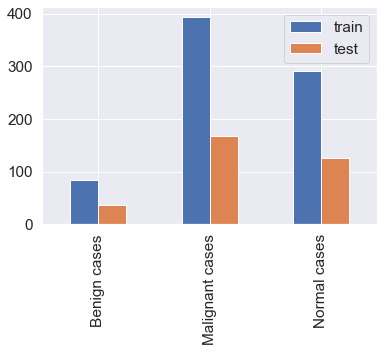

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

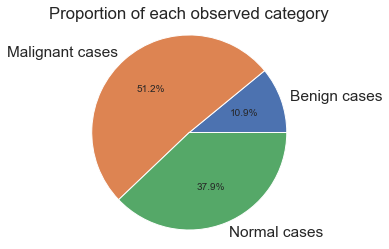

In [8]:
plt.pie(train_counts,
        explode=None , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [10]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [11]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [12]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) 
layer_input = Input(shape = (9, 9, 512)) 

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(3,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [13]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
new_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 9, 9, 512)]       0         
_________________________________________________________________
block5_conv1 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 32)          147488    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 32)         

In [15]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
5/5 [==============================] - 9s 2s/step - loss: 1.3470 - accuracy: 0.5163 - val_loss: 0.9814 - val_accuracy: 0.5260
Epoch 2/20
5/5 [==============================] - 10s 2s/step - loss: 0.9767 - accuracy: 0.4756 - val_loss: 0.9695 - val_accuracy: 0.5455
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 0.9010 - accuracy: 0.6156 - val_loss: 0.7837 - val_accuracy: 0.5519
Epoch 4/20
5/5 [==============================] - 9s 2s/step - loss: 0.8132 - accuracy: 0.6482 - val_loss: 0.7263 - val_accuracy: 0.6623
Epoch 5/20
5/5 [==============================] - 9s 2s/step - loss: 0.7674 - accuracy: 0.6906 - val_loss: 0.7163 - val_accuracy: 0.7078
Epoch 6/20
5/5 [==============================] - 9s 2s/step - loss: 0.6174 - accuracy: 0.7769 - val_loss: 0.5374 - val_accuracy: 0.7922
Epoch 7/20
5/5 [==============================] - 10s 2s/step - loss: 0.4971 - accuracy: 0.8160 - val_loss: 0.4255 - val_accuracy: 0.8312
Epoch 8/20
5/5 [======================

In [16]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8389057750759878


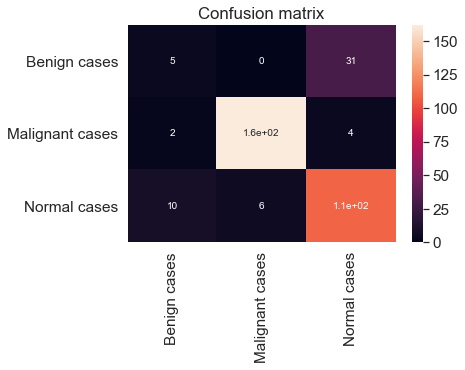

In [17]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [18]:
#Print Classification Report
from sklearn.metrics import classification_report
print('Classification Report')

print(classification_report(test_labels,pred_labels))

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.14      0.19        36
           1       0.96      0.96      0.96       168
           2       0.76      0.87      0.81       125

    accuracy                           0.84       329
   macro avg       0.67      0.66      0.65       329
weighted avg       0.81      0.84      0.82       329



Text(0.5, 1.0, 'Accuracy Curves for CNN model with VGG16 Feature extraction without Processed Dataset')

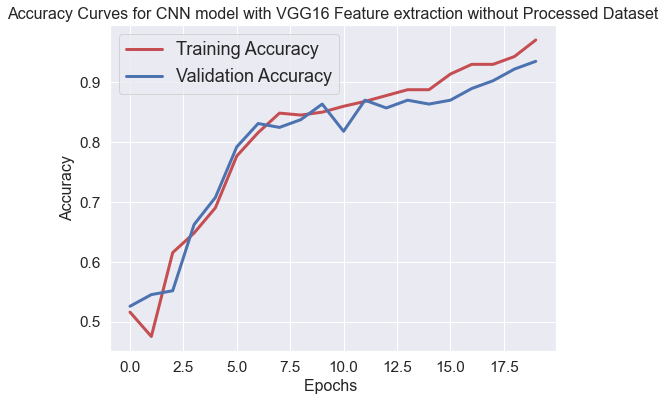

In [19]:
# Accuracy Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['accuracy'],'r',linewidth=3.0)

plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)

plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)

plt.title('Accuracy Curves for CNN model with VGG16 Feature extraction without Processed Dataset',fontsize=16)

Text(0.5, 1.0, 'Loss Curves for CNN model with VGG16 Feature extraction without Processed Dataset')

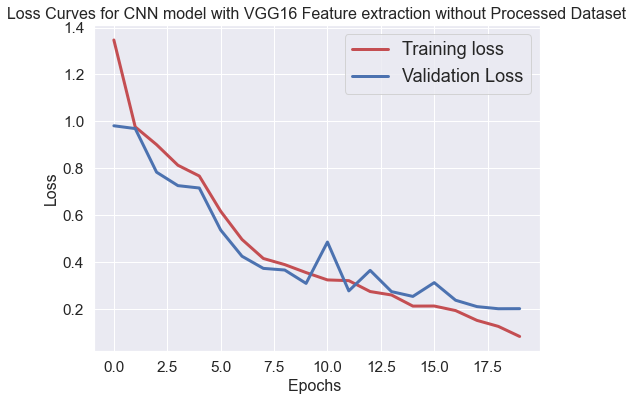

In [20]:
# Loss Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['loss'],'r',linewidth=3.0)

plt.plot(history.history['val_loss'],'b',linewidth=3.0)

plt.legend(['Training loss', 'Validation Loss'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Loss',fontsize=16)

plt.title('Loss Curves for CNN model with VGG16 Feature extraction without Processed Dataset',fontsize=16)